In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
from desmin_reconstruction.analysis.ripley import angular_ripley_H, angular_ripley_H_3d
from desmin_reconstruction.plotting import clustered_scatterplot, line_and_bandplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from hdbscan import HDBSCAN
from tqdm import tqdm


df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_filtered.csv")
out = df.partition_by("probe")

pv.set_jupyter_backend("static")

df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")
points = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df.partition_by("probe"))
}


In [2]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [3]:
idx = 15
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn_sq, metrics_sq = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-5, 5, 0.001),
        rotation_sweep_values=np.arange(-4, 4, 0.1),
        min_cluster_size=500,
        min_samples=10,
    )

sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

100%|██████████| 80/80 [00:07<00:00, 10.14it/s]


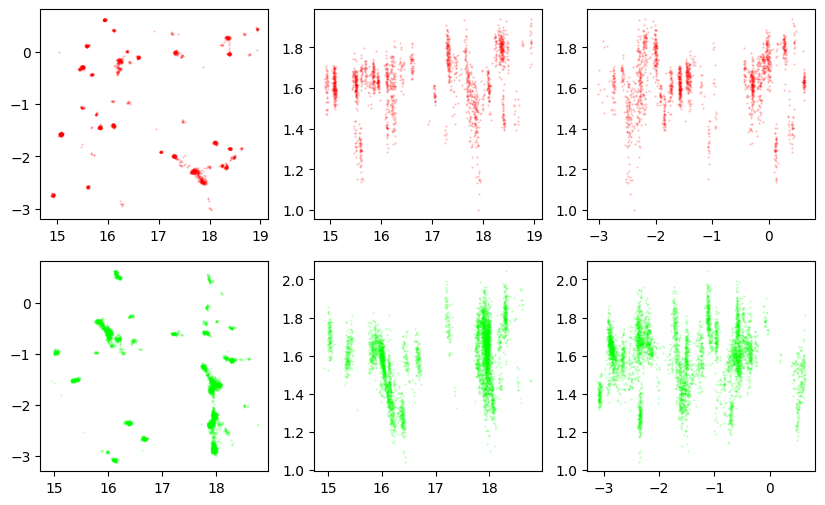

In [4]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1_final[protein][:, ax1],
            sq1_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


2025-12-17 15:56:04.610 (  16.876s) [    1463799FB740]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


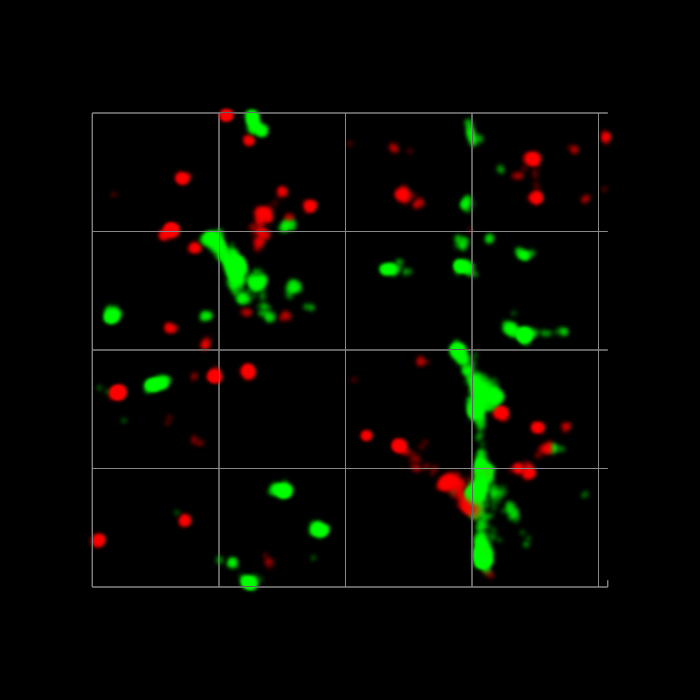

In [5]:
import pyvista as pv


p = pv.Plotter(notebook=True, window_size=(700, 700))
for protein in ("desmin", "actinin"):
    point_cloud = pv.PolyData(sq1_final[protein])
    point_cloud = point_cloud.project_points_to_plane(
        origin=[0, 0, 0], normal=[0, 0, 1]
    )
    p.add_mesh(
        point_cloud,
        color=COLOR_DICT[protein],
        style="points_gaussian",
        # emissive=True,
        point_size=5,
        opacity=0.2,
    )

p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="#888888",
    grid="back",
    bold=False,
    font_size=20,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
axis.x_axis_label_visibility = False
axis.y_axis_label_visibility = False
axis.z_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()
# p.save_graphic("../figures/fig_3/3a/overlay_2d.svg")

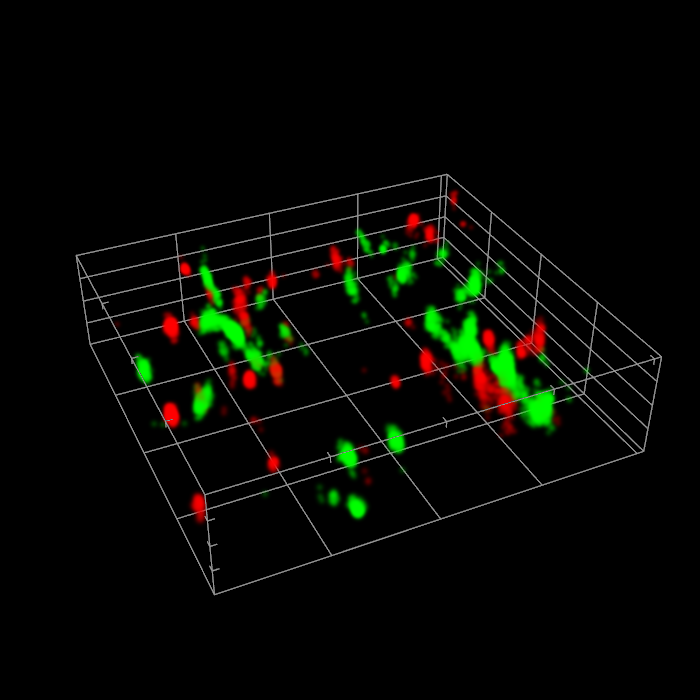

In [6]:
import pyvista as pv


p = pv.Plotter(notebook=True, window_size=(700, 700))
for protein in ("desmin", "actinin"):
    point_cloud = pv.PolyData(sq1_final[protein])
    # point_cloud = point_cloud.project_points_to_plane(
    #     origin=[0, 0, 0], normal=[0, 0, 1]
    # )
    p.add_mesh(
        point_cloud,
        color=COLOR_DICT[protein],
        style="points_gaussian",
        # emissive=True,
        point_size=5,
        opacity=0.2,
    )

p.set_background(color="black")
# p.enable_parallel_projection()

# p.view_xy()
axis = p.show_bounds(
    color="#999999",
    grid="back",
    bold=False,
    font_size=20,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    # show_zaxis=False,
    xtitle="",
    ytitle="",
)
axis.x_axis_label_visibility = False
axis.y_axis_label_visibility = False
axis.z_axis_label_visibility = False
p.camera.azimuth = 200
p.camera.zoom(0.9)
# p.camera.tight(padding=0.5)
p.show()
# p.save_graphic("../figures/fig_3/3b/overlay_3d.svg")

In [7]:
angular_h_dict = {k: angular_ripley_H(v[:, :2], 0.5) for k, v in sq1_final.items()}

  0%|          | 0/1840 [00:00<?, ?it/s]

100%|█████████▉| 4664/4665 [00:00<00:00, 5023.93it/s]


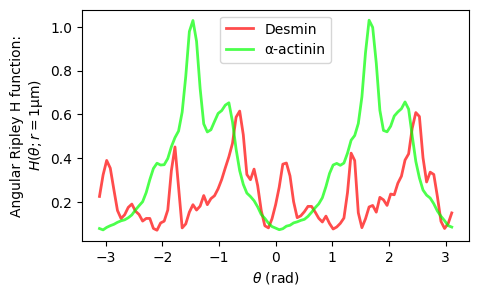

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

LABEL_DICT = {"desmin": "Desmin", "actinin": "α-actinin"}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
for name, dist in angular_h_dict.items():
    ax.plot(
        *dist,
        alpha=0.7,
        linewidth=2.0,
        color=COLOR_DICT[name],
        label=LABEL_DICT[name],
    )

ax.set_xlabel(r"$\theta$" + " (rad)")
ax.set_ylabel("Angular Ripley H function:\n" + r"$H(\theta; r=1\text{μm})$")
# ax.set_xlim((-0.02, 0.52))
ax.legend()

In [9]:
ripley_H_rois = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-5, 5, 0.001),
            rotation_sweep_values=np.arange(-4, 4, 0.1),
            min_cluster_size=500,
            min_samples=10,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

    angular_ripleys = {k: angular_ripley_H(v[:, :2], 0.5) for k, v in sq1_final.items()}
    ripley_H_rois.append(angular_ripleys)

100%|██████████| 16/16 [05:26<00:00, 20.39s/it]


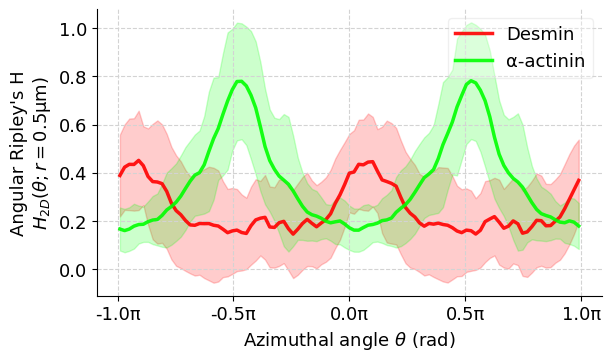

In [10]:
from desmin_reconstruction.plotting import line_and_bandplot


ripley_total = {k: [r[k][1] for r in ripley_H_rois] for k in ("desmin", "actinin")}
angles = ripley_H_rois[0]["desmin"][0]

plt.rc("font", size=13)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), constrained_layout=True)
for protein, h in ripley_total.items():
    ax = line_and_bandplot(
        ax,
        angles,
        np.mean(h, axis=0),
        np.std(h, axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.5,
        alpha=0.9,
        alpha_band=0.2,
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Azimuthal angle " + r"$\theta$" + " (rad)")
ax.set_ylabel("Angular Ripley's H\n" + r"$H_{2D}(\theta; r=0.5\text{μm})$")
ax.legend(loc="upper right", framealpha=0.3)
ax.set_xticks(
    [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
    ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
)
# fig.savefig("../figures/fig_3/3a/angular_ripley_2d.svg", dpi=500)

In [21]:
ripley_H_rois_3d = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-5, 5, 0.001),
            rotation_sweep_values=np.arange(-4, 4, 0.1),
            min_cluster_size=500,
            min_samples=10,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

    angular_ripleys_3d = {
        k: angular_ripley_H_3d(v, 1.0, edge_correction=True)
        for k, v in sq1_final.items()
    }
    ripley_H_rois_3d.append(angular_ripleys_3d)

100%|██████████| 80/80 [00:14<00:00,  5.49it/s]
/home/jhko725/projects/desmin_reconstruction/src/desmin_reconstruction/analysis/ripley.py:136: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:08<00:00,  9.28it/s]
/home/jhko725/projects/desmin_reconstruction/src/desmin_reconstruction/analysis/ripley.py:136: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:08<00:00,  9.63it/s]
/home/jhko725/projects/desmin_reconstruction/src/desmin_reconstruction/analysis/ripley.py:136: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:12<00:00,  6.42it/s]
/home/jhko725/projects/desmin_reconstruction/src/desmin_reconstruction/analysis/ripley.py:136: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:10<00:00,  7.41it/s]
/home/jhko725/projects/desmin_reconstruction/src

In [25]:
ripley_H_3d = {k: [r[k][0] for r in ripley_H_rois_3d] for k in ("desmin", "actinin")}
bins = ripley_H_rois_3d[0]["desmin"][1]
bin_centers = [(b[1:] + b[:-1]) / 2 for b in bins]

Text(0.5, 0.98, "Angular Ripley's H function: $H_{3D}(\\theta, \\varphi; r=0.5\\text{μm})$")

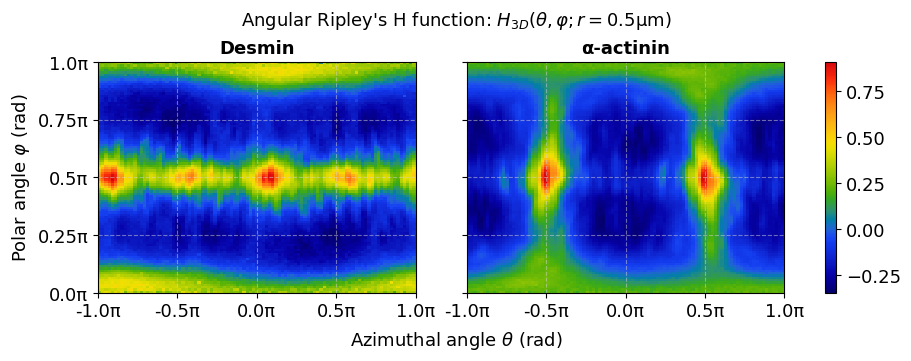

In [26]:
import colorcet as cc


fig, axes = plt.subplots(
    1, 2, figsize=(9, 3.5), sharey=True, sharex=True, constrained_layout=True
)
for ax, protein in zip(axes, ("desmin", "actinin")):
    mesh = ax.pcolormesh(
        *bins,
        np.mean(ripley_H_3d[protein], axis=0).T,
        cmap=cc.cm.rainbow4,
        # vmin=0,
        # vmax=0.7,
        antialiased=True,
    )
    ax.set_xticks(
        [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
        ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
    )
    ax.set_yticks(
        [0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi],
        ["0.0π", "0.25π", "0.5π", "0.75π", "1.0π"],
    )

    fig.supxlabel("Azimuthal angle " + r"$\theta$" + " (rad)", fontsize="medium")
    axes[0].set_ylabel("Polar angle " + r"$\varphi$" + " (rad)", fontsize="medium")
    ax.grid(ls="--", color="lightgray", alpha=0.5)

    ax.set_title(
        LABEL_DICT[protein],
        # color=COLOR_DICT[protein],
        fontsize="medium",
        fontweight="semibold",
    )
fig.colorbar(
    mesh,
    ax=axes.ravel().tolist(),
    pad=0.03,
)

fig.suptitle(
    "Angular Ripley's H function: " + r"$H_{3D}(\theta, \varphi; r=0.5\text{μm})$",
    fontsize="medium",
)
# fig.savefig("../figures/fig_3/3b/angular_ripley_3d.svg", dpi=500)

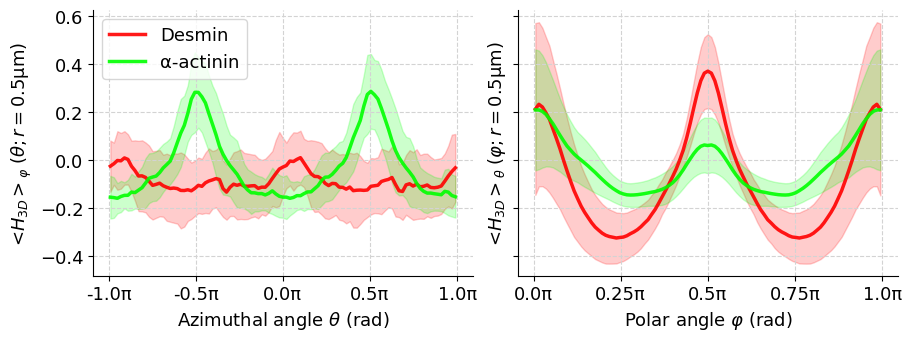

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.3), constrained_layout=True, sharey=True)
for i, ax in enumerate(axes):
    for protein in ("desmin", "actinin"):
        h_3d_proj = np.mean(ripley_H_3d[protein], axis=-(i + 1))
        ax = line_and_bandplot(
            ax,
            bin_centers[i],
            np.mean(h_3d_proj, axis=0),
            np.std(h_3d_proj, axis=0),
            color=COLOR_DICT[protein],
            label=LABEL_DICT[protein],
            linewidth=2.5,
            alpha=0.9,
            alpha_band=0.2,
        )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls="--", color="lightgray")
axes[0].set_xticks(
    [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
    ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
)
axes[0].set_xlabel("Azimuthal angle " + r"$\theta$" + " (rad)")
axes[1].set_xticks(
    [0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi],
    ["0.0π", "0.25π", "0.5π", "0.75π", "1.0π"],
)
axes[1].set_xlabel("Polar angle " + r"$\varphi$" + " (rad)")
axes[0].set_ylabel(r"<$H_{3D}>_{\varphi}\;(\theta; r=0.5\text{μm})$", fontsize="medium")
axes[1].set_ylabel(r"<$H_{3D}>_{\theta}\;(\varphi; r=0.5\text{μm})$", fontsize="medium")
axes[0].legend(loc="upper left")

# fig.savefig("../figures/fig_3/3b/angular_ripley_3d_projections.svg", dpi=500)

# Repeat analysis for 2.5um data

In [370]:
df = pl.read_csv("../data/results/desmin_alphaactinin_2.5um_aligned.csv")
points = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df.partition_by("probe"))
}


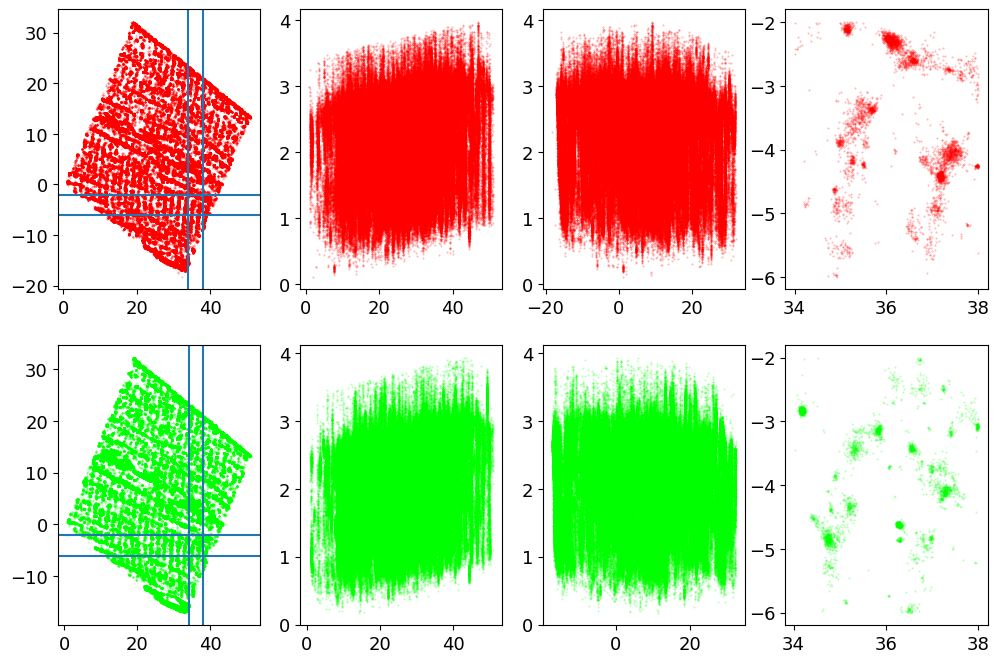

In [445]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

fig, axes = plt.subplots(2, 4, figsize=(12, 8))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points[protein][:, ax1],
            points[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )
for ax in axes[:, 0]:
    x0 = 34
    y0 = -6
    ax.axhline(y=y0)
    ax.axhline(y=y0 + 4)
    ax.axvline(x=x0)
    ax.axvline(x=x0 + 4)

sq1 = {k: filter_bounded(v, BoundingSquare(x0, y0, side=4)) for k, v in points.items()}
for i, protein in enumerate(("desmin", "actinin")):
    axes[i, 3].scatter(
        sq1[protein][:, 0], sq1[protein][:, 1], c=COLOR_DICT[protein], **scatter_kwargs
    )


In [428]:
# x0s = (28, 32, 28, 32, 20, 24, 28, 32, 8, 12, 16, 20, 6, 10, 14, 18, 6, 10)
# y0s = (-14, -14, -10, -10, -6, -6, -6, -6, -2, -2, -2, -2, 2, 2, 2, 2, 6, 6)
x0s = (34, 30, 26, 22, 18, 14)
y0s = (-6, -6, -6, -6, -6, -6)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [474]:
idx = 5
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}


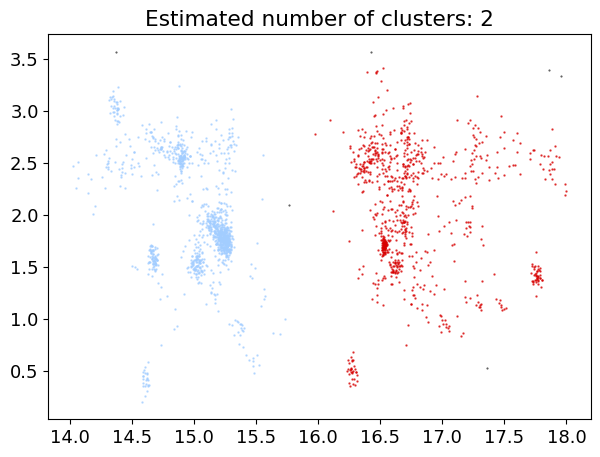

In [475]:
hdbscan_kwargs = {
    "min_cluster_size": 300,
    "min_samples": 10,
    # "cluster_selection_epsilon": 0.1,
}
clusterer = HDBSCAN(**hdbscan_kwargs)
xz = sq1["actinin"][:, np.array([0, 2])]
clusterer.fit(xz)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = clustered_scatterplot(ax, xz, clusterer.labels_)

100%|██████████| 40/40 [00:01<00:00, 24.74it/s]


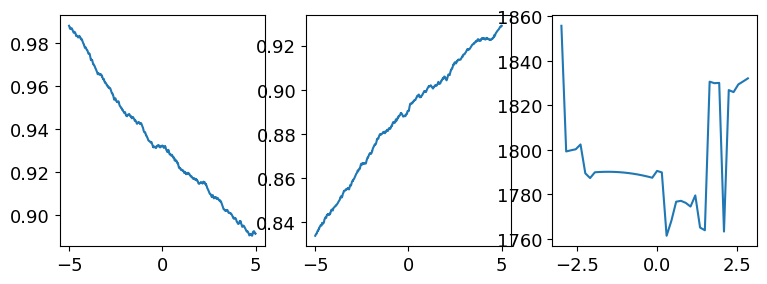

In [476]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn_sq, metrics_sq = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-5, 5, 0.001),
        rotation_sweep_values=np.arange(-3, 3, 0.15),
        **hdbscan_kwargs,
    )

fig, axes = plt.subplots(1, len(metrics_sq), figsize=(9, 3))
for ax, metric in zip(axes, metrics_sq):
    ax.plot(*metric)
sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

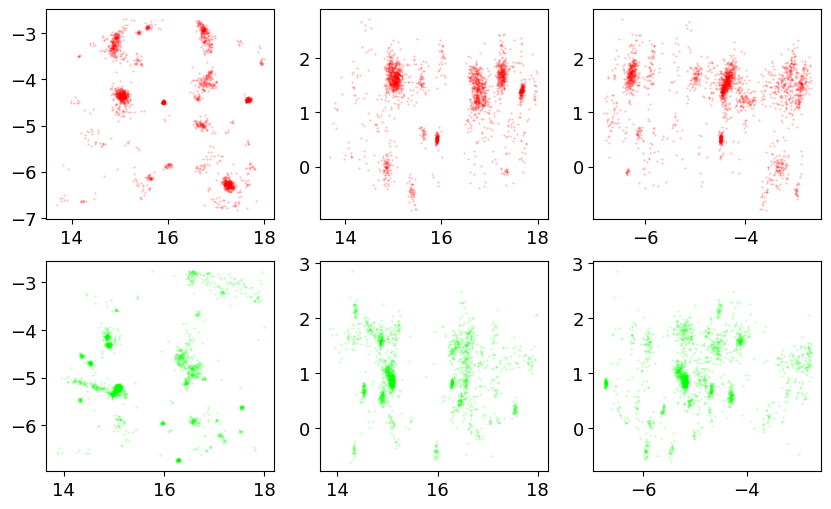

In [477]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1_final[protein][:, ax1],
            sq1_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


In [478]:
angular_h_dict = {
    k: angular_ripley_H_3d(v, 1.0, edge_correction=False) for k, v in sq1_final.items()
}

  0%|          | 0/2280 [00:00<?, ?it/s]

100%|██████████| 2030/2030 [00:00<00:00, 3851.49it/s]


Text(0.5, 0.98, "Angular Ripley's H function: $H_{3D}(\\theta, \\varphi; r=0.5\\text{μm})$")

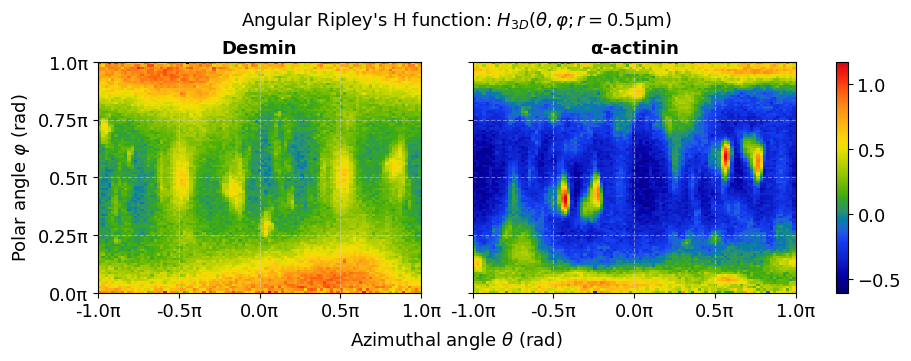

In [ ]:
import colorcet as cc


bins = angular_h_dict["desmin"][1]
fig, axes = plt.subplots(
    1, 2, figsize=(9, 3.5), sharey=True, sharex=True, constrained_layout=True
)
for ax, protein in zip(axes, ("desmin", "actinin")):
    mesh = ax.pcolormesh(
        *bins,
        # ripley_H_3d[protein][15].T,
        angular_h_dict[protein][0].T,
        cmap=cc.cm.rainbow4,
        # vmin=0,
        # vmax=0.7,
        antialiased=True,
    )
    ax.set_xticks(
        [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
        ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
    )
    ax.set_yticks(
        [0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi],
        ["0.0π", "0.25π", "0.5π", "0.75π", "1.0π"],
    )

    fig.supxlabel("Azimuthal angle " + r"$\theta$" + " (rad)", fontsize="medium")
    axes[0].set_ylabel("Polar angle " + r"$\varphi$" + " (rad)", fontsize="medium")
    ax.grid(ls="--", color="lightgray", alpha=0.5)

    ax.set_title(
        LABEL_DICT[protein],
        # color=COLOR_DICT[protein],
        fontsize="medium",
        fontweight="semibold",
    )
fig.colorbar(
    mesh,
    ax=axes.ravel().tolist(),
    pad=0.03,
)

fig.suptitle(
    "Angular Ripley's H function: " + r"$H_{3D}(\theta, \varphi; r=0.5\text{μm})$",
    fontsize="medium",
)
# fig.savefig("../figures/fig_3/3b/angular_ripley_3d.svg", dpi=500)

In [435]:
ripley_H_rois_3d = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points.items()}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-5, 5, 0.001),
            rotation_sweep_values=np.arange(-3, 3, 0.15),
            min_cluster_size=100,
            min_samples=10,
            cluster_selection_epsilon=0.1,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

    angular_ripleys_3d = {
        k: angular_ripley_H_3d(v, 1.0, edge_correction=False)
        for k, v in sq1_final.items()
    }
    ripley_H_rois_3d.append(angular_ripleys_3d)

100%|██████████| 6/6 [01:26<00:00, 14.48s/it]


In [436]:
ripley_H_3d = {k: [r[k][0] for r in ripley_H_rois_3d] for k in ("desmin", "actinin")}
bins = ripley_H_rois_3d[0]["desmin"][1]
bin_centers = [(b[1:] + b[:-1]) / 2 for b in bins]

Text(0.5, 0.98, "Angular Ripley's H function: $H_{3D}(\\theta, \\varphi; r=0.5\\text{μm})$")

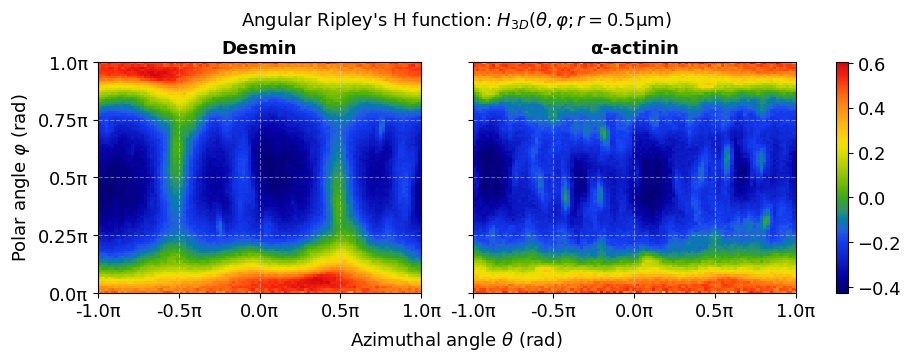

In [437]:
import colorcet as cc


fig, axes = plt.subplots(
    1, 2, figsize=(9, 3.5), sharey=True, sharex=True, constrained_layout=True
)
for ax, protein in zip(axes, ("desmin", "actinin")):
    mesh = ax.pcolormesh(
        *bins,
        np.mean(ripley_H_3d[protein], axis=0).T,
        cmap=cc.cm.rainbow4,
        # vmin=0,
        # vmax=0.4,
        antialiased=True,
    )
    ax.set_xticks(
        [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
        ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
    )
    ax.set_yticks(
        [0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi],
        ["0.0π", "0.25π", "0.5π", "0.75π", "1.0π"],
    )

    fig.supxlabel("Azimuthal angle " + r"$\theta$" + " (rad)", fontsize="medium")
    axes[0].set_ylabel("Polar angle " + r"$\varphi$" + " (rad)", fontsize="medium")
    ax.grid(ls="--", color="lightgray", alpha=0.5)

    ax.set_title(
        LABEL_DICT[protein],
        # color=COLOR_DICT[protein],
        fontsize="medium",
        fontweight="semibold",
    )
fig.colorbar(
    mesh,
    ax=axes.ravel().tolist(),
    pad=0.03,
)

fig.suptitle(
    "Angular Ripley's H function: " + r"$H_{3D}(\theta, \varphi; r=0.5\text{μm})$",
    fontsize="medium",
)
# fig.savefig("../figures/fig_3/3b/angular_ripley_3d.svg", dpi=500)

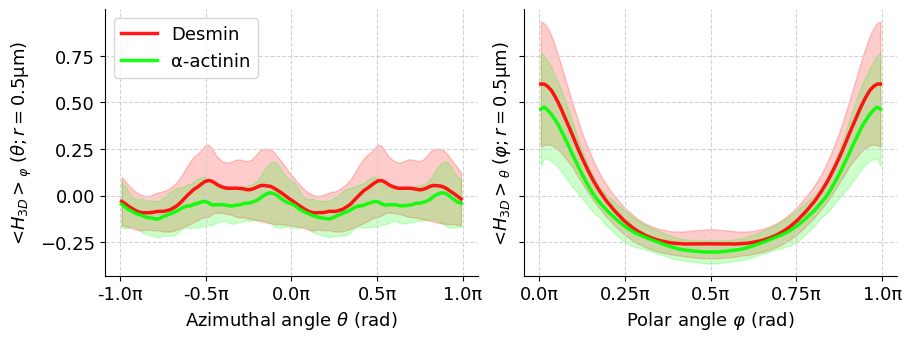

In [399]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.3), constrained_layout=True, sharey=True)
for i, ax in enumerate(axes):
    for protein in ("desmin", "actinin"):
        h_3d_proj = np.mean(ripley_H_3d[protein], axis=-(i + 1))
        ax = line_and_bandplot(
            ax,
            bin_centers[i],
            np.mean(h_3d_proj, axis=0),
            np.std(h_3d_proj, axis=0),
            color=COLOR_DICT[protein],
            label=LABEL_DICT[protein],
            linewidth=2.5,
            alpha=0.9,
            alpha_band=0.2,
        )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls="--", color="lightgray")
axes[0].set_xticks(
    [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
    ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
)
axes[0].set_xlabel("Azimuthal angle " + r"$\theta$" + " (rad)")
axes[1].set_xticks(
    [0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi],
    ["0.0π", "0.25π", "0.5π", "0.75π", "1.0π"],
)
axes[1].set_xlabel("Polar angle " + r"$\varphi$" + " (rad)")
axes[0].set_ylabel(r"<$H_{3D}>_{\varphi}\;(\theta; r=0.5\text{μm})$", fontsize="medium")
axes[1].set_ylabel(r"<$H_{3D}>_{\theta}\;(\varphi; r=0.5\text{μm})$", fontsize="medium")
axes[0].legend(loc="upper left")

# fig.savefig("../figures/fig_3/3b/angular_ripley_3d_projections.svg", dpi=500)